# SVC

In [ ]:
pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29103 sha256=957b46123de26a4a3191f103fbdc969b690f6c35985b32f4f16f66b1e42319f4
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yfin
import ta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
#ML modelos 
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
#medidas de desempeño
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

In [ ]:
df = yfin.download("BTC-USD", start="2016-01-01", end="2021-01-01")
#Calculando los indicadores tecnicos, EMA para tomar desiciones si el P esta porencima o por debajo de EMA
#si dividimos por el precio(para facilitar la tarea), 
#si EMA_s>1 quiere decir que EMA es mayor que el precio actual
#si EMA_s<1 quiere decir que EMA esta por debajo del precio actual
df["EMA_5"] = ta.trend.ema_indicator(close=df["Close"], window=5, fillna=True)/df["Close"]
df["EMA_20"] = ta.trend.ema_indicator(close=df["Close"], window=20, fillna=True)/df["Close"]
df["EMA_50"] = ta.trend.ema_indicator(close=df["Close"], window=50, fillna=True)/df["Close"]
df["EMA_100"] = ta.trend.ema_indicator(close=df["Close"], window=100, fillna=True)/df["Close"]
#Añadimos el indice de fuerza relativa (0-100)
df["RSI"] = ta.momentum.rsi(close=df["Close"], fillna=True)
#Rango verdadero medio
df["ATR"] = ta.volatility.average_true_range(high=df["High"], low=df["Low"], close=df["Close"], fillna=True)
#Rango de porcentaje de Williams
df["WR"] = ta.momentum.williams_r(high=df["High"], low=df["Low"], close=df["Close"], fillna=True)

[*********************100%***********************]  1 of 1 completed


In [ ]:
#Una vez definido las variables de entrada, creamos la variable de salida (-1, 1)
#Nos preguntamos para cada dia si el precio de cierre del dia siguiente subio o bajo con respecto
#al precio de cierre del dia actual
#creamos un vector de los precios de cierre
cl = np.array(df["Close"])
target = np.where(cl[1:] > cl[:-1], 1, -1)
df.drop(df.tail(1).index, inplace=True)
df["Target"] = target

In [ ]:
#Una ultima modificación sera eliminar alguna de las primeras filas donde los indicadores tecnicos no tenian
#la suficiente informacion para ser calculados, en este caso 30 datos, primeras 29 datos
df.drop(df.head(29).index, inplace=True)

In [ ]:
#Necesitamos una matriz donde se tenga las variables de entrada
X = np.array(df.iloc[:,6:-1])
#vector de salida
Y = np.array(df["Target"])
print(X.shape)
print(Y.shape)

(1797, 7)
(1797,)


In [ ]:
#Dividimos estos datos en un conjunto de entrenamiento y de observacion
#usamos libreria Scikit learn
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=False)
print(X_train.shape)
print(X_test.shape)

(1617, 7)
(180, 7)


In [ ]:
#Estandarizamos los datos de entrada, restamos a cada columna se DE y dividirla por su media
#con el fin de que ninguna variable sea mas importante que otra
ss = StandardScaler()
ss = ss.fit(X_train)

X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

In [ ]:
#Primer modelo de Machine Learning, sera una Maquina de Soporte Vectorial
#importamos from sklearn.svm import SVC
#por defecto un kernel radial
svc = SVC()
svc = svc.fit(X_train, Y_train)

In [ ]:
#obtenemos algunas medidas de desempeño
svc_pred = svc.predict(X_test)
accuracy_score(Y_test, svc_pred)

0.5722222222222222

In [ ]:
#Matriz de confusion
confusion_matrix(Y_test, svc_pred)

array([[16, 54],
       [23, 87]])

In [ ]:
#Graficamos la curva ROC, buscar el mayor AUC
#roc_curve(Y_test, X_test, svc)

# Arbol de desición

In [ ]:
#Construimos nuestro arbol de desicion,importamos DesicionTreeClasifier
dtc = DecisionTreeClassifier()
dtc = dtc.fit(X_train, Y_train)

In [ ]:
dtc_pred = dtc.predict(X_test)
accuracy_score(Y_test, dtc_pred)

0.5166666666666667

In [ ]:
confusion_matrix(Y_test, dtc_pred)

array([[37, 33],
       [54, 56]])

# Random Forest

In [ ]:
#Construimos nuestro Random Forest,importamos RandomForestClasifier
rfc = RandomForestClassifier()
rfc = rfc.fit(X_train, Y_train)

In [ ]:
rfc_pred = rfc.predict(X_test)
accuracy_score(Y_test, rfc_pred)

0.5722222222222222

In [ ]:
confusion_matrix(Y_test, rfc_pred)

array([[48, 22],
       [55, 55]])

# Redes Neuronales

In [ ]:
#Construimos nuestro Random Forest,importamos MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=1000)
mlp = mlp.fit(X_train, Y_train)

In [ ]:
mlp_pred = mlp.predict(X_test)
accuracy_score(Y_test, mlp_pred)

0.5388888888888889

In [ ]:
confusion_matrix(Y_test, mlp_pred)

array([[30, 40],
       [43, 67]])

# El mejor modelo es el Random Forest

In [49]:
N =len(Y_test) #Numero de datos
df = df.tail(N) #Extraemos del df los dias que corresponde a la evaluacion
df["Signals"] = rfc_pred

In [45]:
#Haremos BackTesting para evaluar los resultados
equity = [100] #lista, y primer element 100$

#Definimos TP y SL
TP = 0.03
SL = 0.01

#a medida que vamos avanzando en el tiempo necesitamos saber la posicion en la que estamos
pos = 0
price = 0

#Para obtener las señales de trading
for i in range(1, N):
  
  equity.append(equity[i-1])

  if pos == 1:
    if df["Close"][i] >= price*(1+TP):
      pos = 0
      equity[i] = equity[i]*(1+TP)
    elif df["Close"][i] <= price*(1-SL):
      pos = 0
      equity[i] = equity[i]*(1-SL)

  elif pos == -1:
    if df["Close"][i] <= price*(1-TP):
      pos = 0
      equity[i] = equity[i]*(1+TP)
    elif df["Close"][i] >= price*(1+SL):
      pos = 0
      equity[i] = equity[i]*(1-SL)

  else:
    if df["Signals"][i] !=0:
      pos = df["Signals"][i]
      price = df["Close"][i]
df["Equity"] = equity

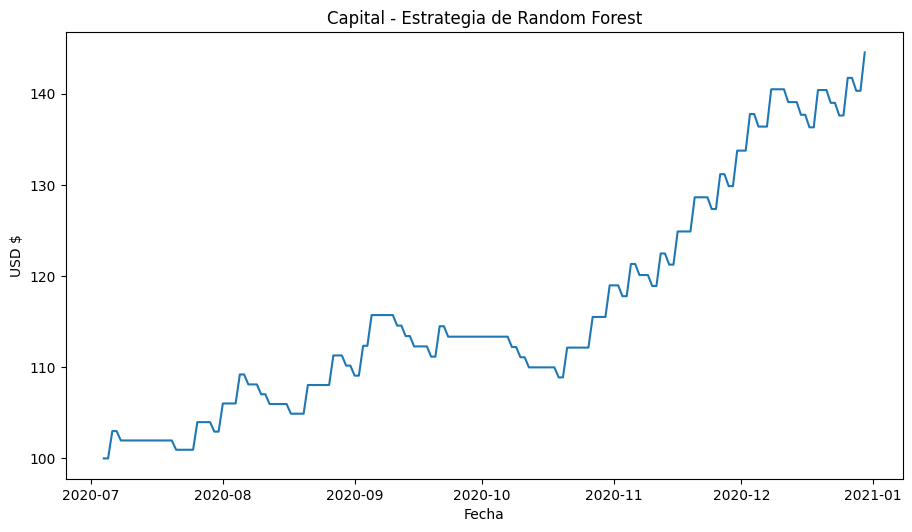

In [46]:
#Mostrar el Equity a lo largo del tiempo
plt.figure(figsize=(10.8, 5.8))
plt.plot(df["Equity"])
plt.title("Capital - Estrategia de Random Forest")
plt.xlabel("Fecha")
plt.ylabel("USD $")
plt.show()

In [47]:
#Indicador de retornos de la estrategia con la volatilidad
#retorno diario
ret =np.log(df["Equity"]).diff().mean()
#retorno anualizado
ret *= 252
ret
#volatilidad de los retornos diarios
vol = np.log(df["Equity"]).diff().std()
#Volatilidad anual
vol *= np.sqrt(252)
vol
#Tasa libre de riesgo
rf = 0.01

#Ratio de Sharp
sharp_ratio = (ret-rf)/vol
sharp_ratio

2.851006862434821

In [53]:
df2 = yfin.download("^GSPC", start="2020-07-04", end="2020-12-30") #cambiamos las fechas
#Si hubieramos invertido 100 en S&P
df2["Equity"] = (100/df2["Close"][0])*df2["Close"]

[*********************100%***********************]  1 of 1 completed


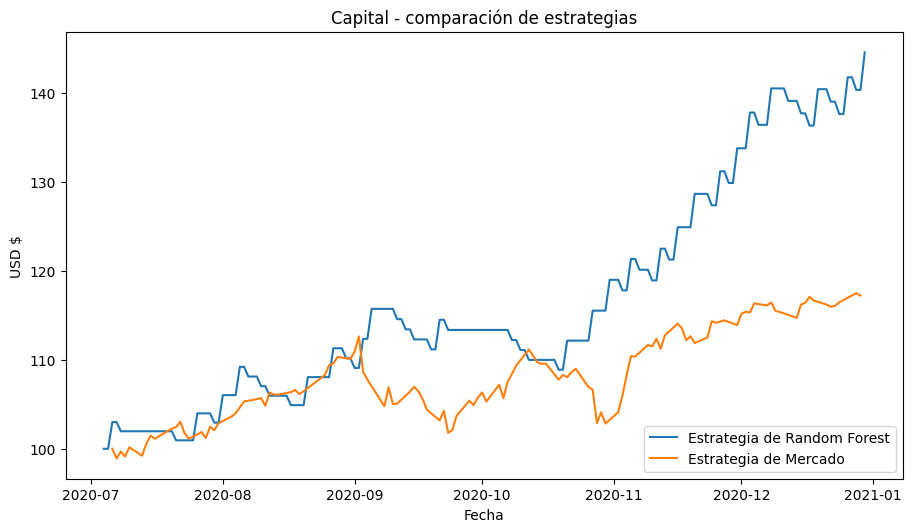

In [54]:
#Comparamos las estrategias
plt.figure(figsize=(10.8, 5.8))
plt.plot(df["Equity"], label="Estrategia de Random Forest")
plt.plot(df2["Equity"], label="Estrategia de Mercado")
plt.title("Capital - comparación de estrategias")
plt.xlabel("Fecha")
plt.ylabel("USD $")
plt.legend(loc="lower right")
plt.show()

In [56]:
#Indicador de retornos de la estrategia con la volatilidad
#retorno diario
ret =np.log(df2["Equity"]).diff().mean()
#retorno anualizado
ret *= 252
ret
#volatilidad de los retornos diarios
vol = np.log(df2["Equity"]).diff().std()
#Volatilidad anual
vol *= np.sqrt(252)
vol
#Tasa libre de riesgo
rf = 0.01

#Ratio de Sharp
sharp_ratio = (ret-rf)/vol
sharp_ratio #fue mejor el Random Forest debido a que tiene un mejor Sharp_Ratio

1.8812541679093144